# Cell 1: Import Libraries

(Common libraries for image processing, evaluation, and deep learning)

In [18]:
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [19]:
! pip install numpy opencv-python matplotlib scikit-learn scikit-image torch torchvision


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.morphology import disk, binary_closing
from skimage.segmentation import flood
from skimage.util import img_as_ubyte
from sklearn.cluster import KMeans
import zipfile
from io import BytesIO


import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim


# Cell 2: Define Utility Functions for Evaluation Metrics

(Defines IoU and Dice score functions used for evaluation in both parts)

In [39]:
def compute_iou(y_true, y_pred, threshold=0.5):
    """
    Compute Intersection over Union (IoU) for binary masks.
    Automatically binarizes and resizes the predictions.
    """
    # Ensure both masks are same size
    if y_true.shape != y_pred.shape:
        y_pred = cv2.resize(y_pred, (y_true.shape[1], y_true.shape[0]))

    # Auto-binarize both masks
    y_true = (y_true > 0).astype(np.uint8)
    y_pred = (y_pred > threshold * 255).astype(np.uint8)

    # Compute Intersection & Union
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection

    return intersection / (union + 1e-6)


def compute_dice(y_true, y_pred, threshold=0.5):
    """
    Compute Dice Score for binary masks.
    Automatically binarizes and resizes the predictions.
    """
    # Ensure both masks are same size
    if y_true.shape != y_pred.shape:
        y_pred = cv2.resize(y_pred, (y_true.shape[1], y_true.shape[0]))

    # Auto-binarize both masks
    y_true = (y_true > 0).astype(np.uint8)
    y_pred = (y_pred > threshold * 255).astype(np.uint8)

    # Compute Intersection
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-6)


# Cell 3: Load Sample Image and Ground Truth Mask

(Loads one sample image from “face_crop” and its corresponding ground truth mask from “face_crop_segmentation”. Adjust file names as needed.)

In [5]:

# Define Zip Path & Internal Folders
zip_file_path = "datasets/MSFD.zip"  # Path to local zip file
zip_file = zipfile.ZipFile(zip_file_path)
image_folder = "MSFD/1/face_crop"
mask_folder = "MSFD/1/face_crop_segmentation"

# Get All Image & Mask File Paths
all_files = zip_file.namelist()
image_files = sorted([f for f in all_files if f.startswith(image_folder) and not f.endswith('/')])
mask_files = sorted([f for f in all_files if f.startswith(mask_folder) and not f.endswith('/')])

# Ensure Every Image Has a Corresponding Mask
valid_image_files = []
valid_mask_files = []

for img in image_files:
    mask = img.replace("face_crop", "face_crop_segmentation")  # Match the mask path
    if mask in mask_files:  # Keep only matched pairs
        valid_image_files.append(img)
        valid_mask_files.append(mask)

print(f"Filtered {len(valid_image_files)} valid image-mask pairs.")

# Read Image Helper Function
def read_image_from_zip(zip_obj, file_path, flag=cv2.IMREAD_COLOR):
    with zip_obj.open(file_path) as file:
        file_bytes = BytesIO(file.read())
        image = cv2.imdecode(np.frombuffer(file_bytes.read(), np.uint8), flag)
        if image is None:
            raise FileNotFoundError(f"Error reading file: {file_path}")
    return image


Filtered 9382 valid image-mask pairs.


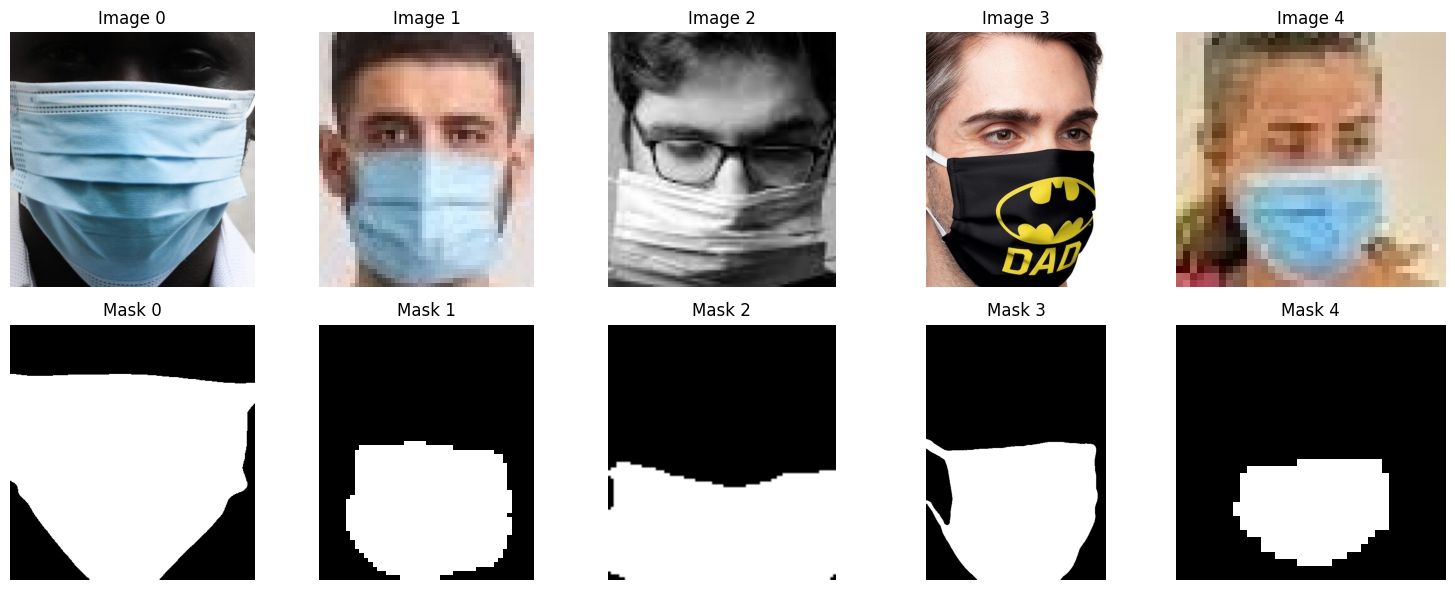

In [35]:
plt.figure(figsize=(15, 6))
for i in range(5):
    # Load and display the image (convert to RGB)
    img = read_image_from_zip(zip_file, valid_image_files[i], flag=cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"Image {i}")
    plt.axis("off")

    # Load and display the corresponding mask (binarize mask)
    mask = read_image_from_zip(zip_file, valid_mask_files[i], flag=cv2.IMREAD_GRAYSCALE)
    mask = (mask > 127).astype(np.uint8)

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Cell 5: c(i) - Traditional Region Segmentation Implementation

(Apply traditional techniques such as thresholding and edge detection on a sample image)

	Note: For demonstration, we use the first sample image loaded in the previous cell

In [36]:

idx = 0  # <-- Change this index to select which sample to process

# 1) Retrieve the chosen image (RGB) and ground truth mask (0/1)
img_chosen = read_image_from_zip(zip_file, valid_image_files[idx], flag=cv2.IMREAD_COLOR)
gt_mask_chosen = read_image_from_zip(zip_file, valid_mask_files[idx], flag=cv2.IMREAD_GRAYSCALE)

# 2) Convert the loaded image to Grayscale
gray = cv2.cvtColor(img_chosen, cv2.COLOR_RGB2GRAY)

# 3) Apply Otsu thresholding
_, mask_bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 4) Morphological Closing to fill small gaps
kernel = np.ones((5, 5), np.uint8)
closed_mask = cv2.morphologyEx(mask_bin, cv2.MORPH_CLOSE, kernel, iterations=2)

# 5) Apply Median Blur and Normalize the Image
blurred = cv2.medianBlur(gray, 11)
norm_image = blurred.astype(np.float32) / 255.0

# 6) Define Seed Point for Flood Fill
height, width = norm_image.shape
seed_point = (height // 2, width // 2)

# 7) Flood Fill with a Tolerance of 0.4
mask = flood(norm_image, seed_point, tolerance=0.4)

# 8) Convert to Binary and Apply Morphological Closing
segmented_display = img_as_ubyte(mask)
segmented_display = binary_closing(segmented_display, disk(5)).astype(np.uint8) * 255


# Cell 6: c(ii) - Visualization and Evaluation of Traditional Segmentation

(Visualize the segmentation results and compute evaluation metrics against the ground truth for the first sample)

(np.float64(-0.5), np.float64(387.5), np.float64(404.5), np.float64(-0.5))

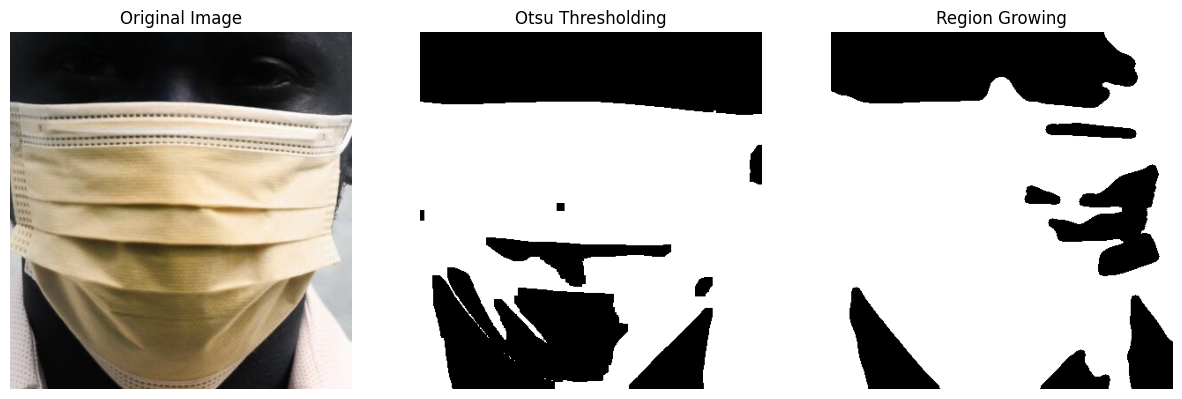

In [37]:
# show outputs of both otsu and of region growing

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.imshow(img_chosen)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(closed_mask, cmap='gray')
plt.title("Otsu Thresholding")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(segmented_display, cmap='gray')
plt.title("Region Growing")
plt.axis("off")



In [40]:

# compute scores for both masks
iou_otsu = compute_iou(gt_mask_chosen, closed_mask)
dice_otsu = compute_dice(gt_mask_chosen, closed_mask)

iou_rg = compute_iou(gt_mask_chosen, segmented_display)
dice_rg = compute_dice(gt_mask_chosen, segmented_display)

print(f"Otsu Thresholding: IoU={iou_otsu:.3f}, Dice={dice_otsu:.3f}")
print(f"Region Growing: IoU={iou_rg:.3f}, Dice={dice_rg:.3f}")

Otsu Thresholding: IoU=0.707, Dice=0.828
Region Growing: IoU=0.776, Dice=0.874


Even though Otsu is slightly better, we use Region growing as it is much faster, on the entire dataset.

In [41]:
def process_image(img_chosen, gt_mask_chosen):
    """Segment using region growing and compute IoU/Dice."""
    gray = cv2.cvtColor(img_chosen, cv2.COLOR_RGB2GRAY)
    blurred = cv2.medianBlur(gray, 11)
    norm_image = blurred.astype(np.float32) / 255.0
    height, width = norm_image.shape
    seed_point = (height // 2, width // 2)
    mask = flood(norm_image, seed_point, tolerance=0.4)
    segmented_display = img_as_ubyte(mask)
    segmented_display = binary_closing(segmented_display, disk(5)).astype(np.uint8) * 255

    # Resize predicted mask to match ground truth dimensions
    segmented_display = cv2.resize(segmented_display, (gt_mask_chosen.shape[1], gt_mask_chosen.shape[0]))

    # Calculate IoU and Dice
    iou = compute_iou(gt_mask_chosen, segmented_display)
    dice = compute_dice(gt_mask_chosen, segmented_display)

    return iou, dice



# calculating the mean iou and dice scores for the sample images

total_iou = 0
total_dice = 0
total_images = 0

# for all images:
for i in range( len(valid_image_files) ):
    # print progress
    print(f"Processing image {i+1}")
    img_chosen = read_image_from_zip(zip_file, valid_image_files[i], flag=cv2.IMREAD_COLOR)
    gt_mask_chosen = read_image_from_zip(zip_file, valid_mask_files[i], flag=cv2.IMREAD_GRAYSCALE)

    iou, dice = process_image(img_chosen, gt_mask_chosen)


    total_iou += iou
    total_dice += dice
    total_images += 1

mean_iou = total_iou / total_images
mean_dice = total_dice / total_images

print(f"Mean IoU: {mean_iou:.3f}")

print(f"Mean Dice: {mean_dice:.3f}")

    


Processing image 1
Processing image 2
Processing image 3
Processing image 4
Processing image 5
Processing image 6
Processing image 7
Processing image 8
Processing image 9
Processing image 10
Processing image 11
Processing image 12
Processing image 13
Processing image 14
Processing image 15
Processing image 16
Processing image 17
Processing image 18
Processing image 19
Processing image 20
Processing image 21
Processing image 22
Processing image 23
Processing image 24
Processing image 25
Processing image 26
Processing image 27
Processing image 28
Processing image 29
Processing image 30
Processing image 31
Processing image 32
Processing image 33
Processing image 34
Processing image 35
Processing image 36
Processing image 37
Processing image 38
Processing image 39
Processing image 40
Processing image 41
Processing image 42
Processing image 43
Processing image 44
Processing image 45
Processing image 46
Processing image 47
Processing image 48
Processing image 49
Processing image 50
Processin

# Cell 7: d(i) - U-Net Model Definition for Mask Segmentation

In [6]:

# Define PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, zip_obj, image_files, mask_files, transform=None):
        self.zip_obj = zip_obj
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Read Image & Mask from zip
        image = read_image_from_zip(self.zip_obj, self.image_files[idx])
        mask = read_image_from_zip(self.zip_obj, self.mask_files[idx], cv2.IMREAD_GRAYSCALE)

        # Convert to RGB & Normalize
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256)) / 255.0  # Normalize

        # Binarize Mask
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 127).astype(np.float32)  # Convert to binary mask

        # Convert to Tensors
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # HWC -> CHW
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        return image, mask

# Create Dataset
dataset = CustomDataset(zip_file, valid_image_files, valid_mask_files)


In [8]:
# Split into Train, Validation & Test Sets
# Create Dataset

seed = 42
torch.manual_seed(seed)




train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Train Samples: {len(train_dataset)}, Validation Samples: {len(val_dataset)}, Test Samples: {len(test_dataset)}")


Train Samples: 6567, Validation Samples: 1407, Test Samples: 1408


In [9]:
# Define DoubleConv Block
class DoubleConv(nn.Module):
    """(Conv -> ReLU) * 2 block"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# Define Encoder Block
class EncoderBlock(nn.Module):
    """Encoder block: DoubleConv -> MaxPool"""
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        return x, p

# Define Decoder Block
class DecoderBlock(nn.Module):
    """Decoder block: UpConv -> Skip connection -> DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        diffY = skip.size()[2] - x.size()[2]
        diffX = skip.size()[3] - x.size()[3]
        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)


(Define the U-Net architecture for precise segmentation)

In [10]:
# Define U-Net Model
class UNet(nn.Module):
    """U-Net model"""
    def __init__(self, in_channels=3, num_classes=1):
        super(UNet, self).__init__()
        self.enc1 = EncoderBlock(in_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        self.bottleneck = DoubleConv(512, 1024)

        self.dec1 = DecoderBlock(1024, 512)
        self.dec2 = DecoderBlock(512, 256)
        self.dec3 = DecoderBlock(256, 128)
        self.dec4 = DecoderBlock(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        s1, p1 = self.enc1(x)
        s2, p2 = self.enc2(p1)
        s3, p3 = self.enc3(p2)
        s4, p4 = self.enc4(p3)

        b = self.bottleneck(p4)

        d1 = self.dec1(b, s4)
        d2 = self.dec2(d1, s3)
        d3 = self.dec3(d2, s2)
        d4 = self.dec4(d3, s1)

        return torch.sigmoid(self.final_conv(d4))

# Initialize U-Net Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3).to(device)

# Loss & Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for segmentation
optimizer = Adam(model.parameters(), lr=1e-4)

print("Model, Loss, and Optimizer Ready!")

Model, Loss, and Optimizer Ready!


# Train the U-Net Model

(Train the U-Net model using the prepared training dataset. Adjust batch size and epochs as needed.)

In [ ]:
# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward Pass
            outputs = model(images)

            # Calculate Loss
            loss = criterion(outputs, masks)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation Loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")


In [12]:
# Start Training
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch [1/10] | Train Loss: 0.2979 | Val Loss: 0.2080
Epoch [2/10] | Train Loss: 0.1513 | Val Loss: 0.1525
Epoch [3/10] | Train Loss: 0.1071 | Val Loss: 0.0979
Epoch [4/10] | Train Loss: 0.0897 | Val Loss: 0.0848
Epoch [5/10] | Train Loss: 0.0791 | Val Loss: 0.0903
Epoch [6/10] | Train Loss: 0.0695 | Val Loss: 0.0796
Epoch [7/10] | Train Loss: 0.0638 | Val Loss: 0.0724
Epoch [8/10] | Train Loss: 0.0581 | Val Loss: 0.0765
Epoch [9/10] | Train Loss: 0.0526 | Val Loss: 0.0790
Epoch [10/10] | Train Loss: 0.0477 | Val Loss: 0.0715


In [ ]:
# prompt: save the model

torch.save(model.state_dict(), './saved_models/unet_model.pth')
print("Model saved successfully!")


Model saved successfully!


# d(ii) Evaluate and Compare U-Net Segmentation Performance

In [ ]:
def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss, total_iou, total_dice, total_samples = 0.0, 0.0, 0.0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            # Get predicted masks (assuming sigmoid output)
            predicted = (outputs > 0.5).float()

            # Calculate IoU and Dice for each sample in the batch
            for i in range(inputs.size(0)):
                pred_mask = predicted[i].float()
                true_mask = labels[i].float()
                intersection = (pred_mask * true_mask).sum().item()
                union = pred_mask.sum().item() + true_mask.sum().item() - intersection
                iou = intersection / union if union != 0 else 0
                dice = (2 * intersection) / (pred_mask.sum().item() + true_mask.sum().item()) if (pred_mask.sum().item() + true_mask.sum().item()) != 0 else 0

                total_iou += iou
                total_dice += dice
                total_samples += 1

    avg_loss = total_loss / total_samples
    avg_iou = total_iou / total_samples
    avg_dice = total_dice / total_samples

    print(f'Loss: {avg_loss:.4f} | IoU: {avg_iou:.4f} | Dice Score: {avg_dice:.4f}')
    return avg_loss, avg_iou, avg_dice



In [12]:
# prompt: call evaluaate model

# Load the saved model
model.load_state_dict(torch.load('./saved_models/unet_model.pth'))


C:\Users\Md.Owais\AppData\Local\Temp\ipykernel_26136\2743752802.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./saved_models/unet_mod

<All keys matched successfully>

In [ ]:

# Evaluate the model
test_loss, test_iou, test_dice = evaluate_model(model, test_loader, criterion)



C:\Users\Md.Owais\AppData\Local\Temp\ipykernel_2588\1209895571.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('unet_model.pth'))


Loss: 0.0665 | IoU: 0.9240 | Dice Score: 0.9561



# Visualizing Predictions on Random Test Samples
(Displays original images, ground truth masks, and predicted masks for a few random samples from the test dataset to evaluate the model's performance visually.)


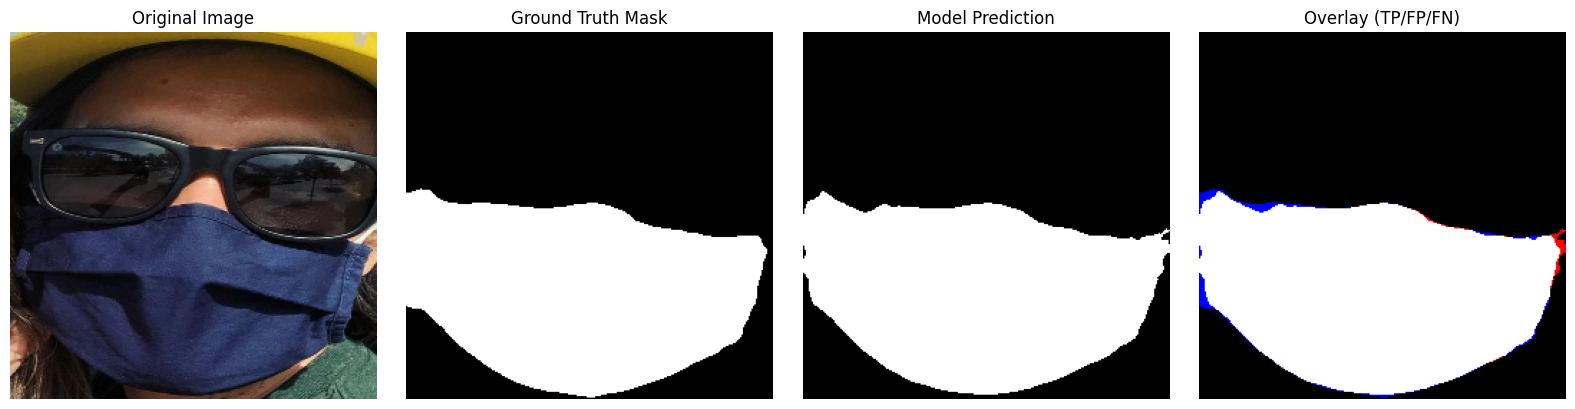

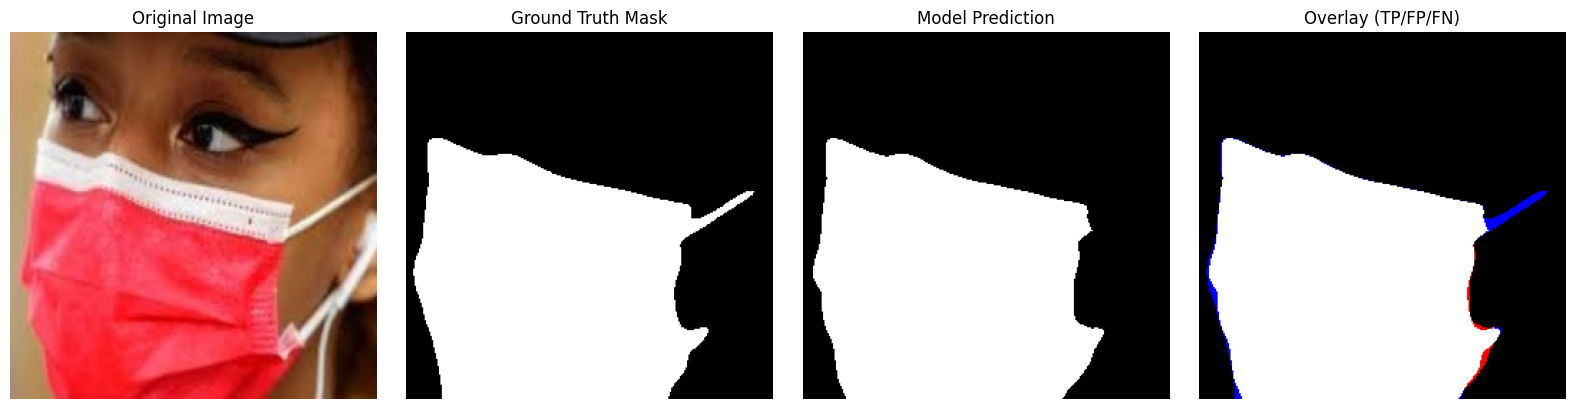

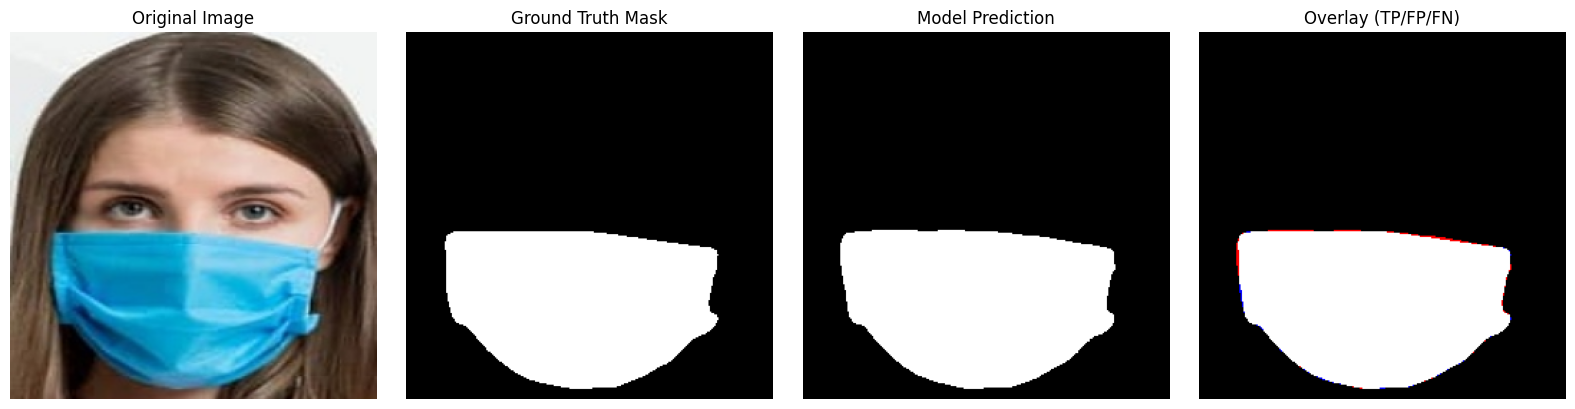

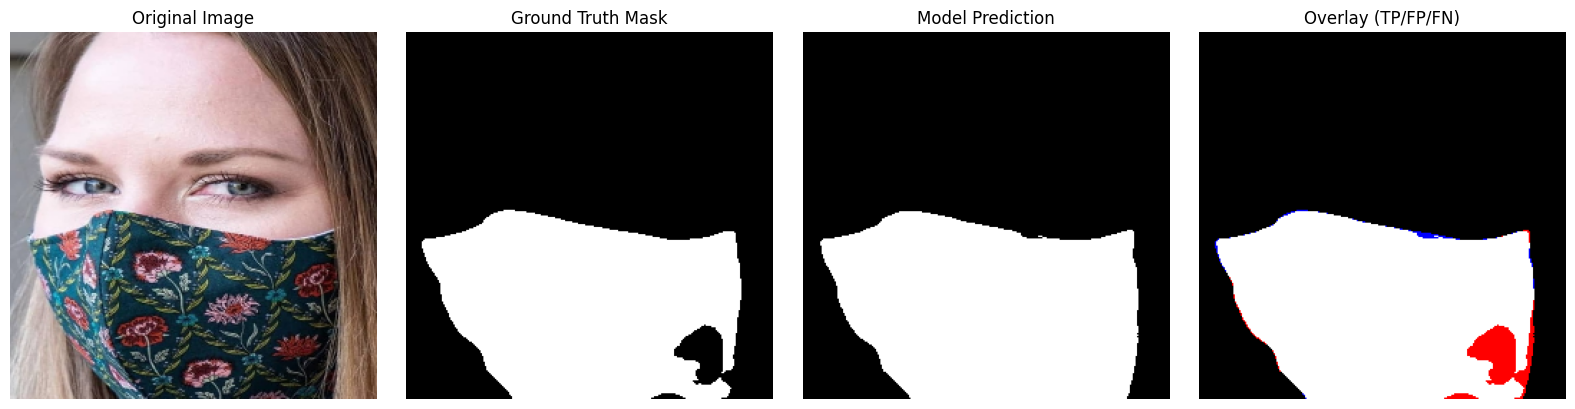

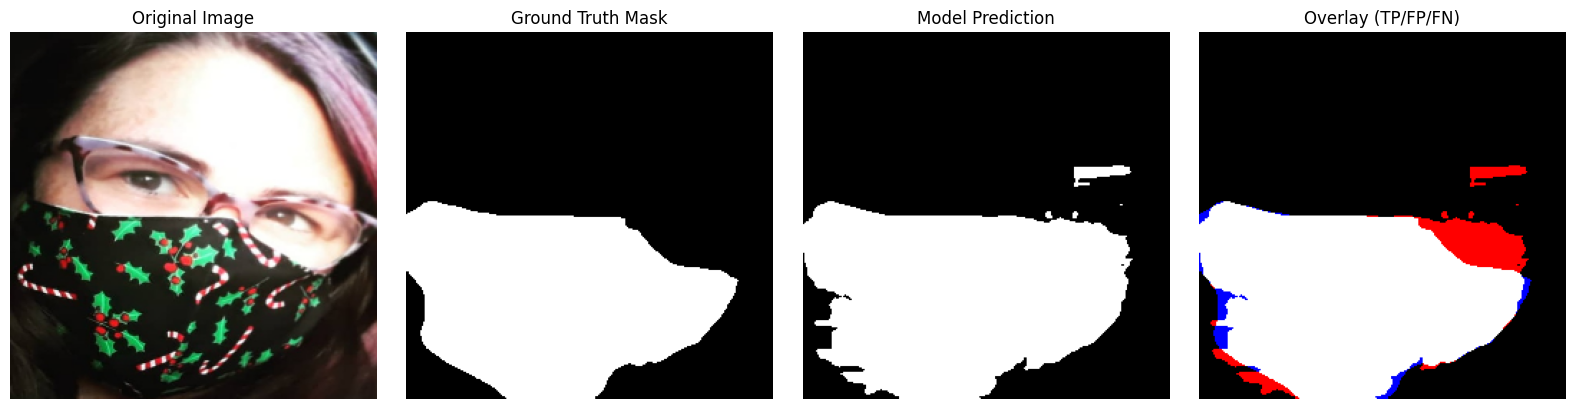

Results saved and displayed successfully in 'output_viz' folder.


In [19]:
import random
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

# Create output directory if it doesn't exist
output_dir = "output_viz"
os.makedirs(output_dir, exist_ok=True)

# Function to create overlay with true positive, false positive, and false negative
def create_overlay(pred, mask):
    pred = pred.squeeze().cpu().numpy() > 0.5  # Convert to binary
    mask = mask.squeeze().cpu().numpy().astype(bool)

    overlay = np.zeros_like(pred, dtype=np.uint8)

    # True Positive (Correctly predicted foreground) -> White
    overlay[(pred == 1) & (mask == 1)] = 255

    # False Positive (Incorrectly predicted as foreground) -> Red
    overlay[(pred == 1) & (mask == 0)] = 1

    # False Negative (Missed foreground) -> Blue
    overlay[(pred == 0) & (mask == 1)] = 2

    # Map values to colors
    color_overlay = np.zeros((overlay.shape[0], overlay.shape[1], 3), dtype=np.uint8)
    color_overlay[overlay == 255] = [255, 255, 255]  # White for TP
    color_overlay[overlay == 1] = [255, 0, 0]        # Red for FP
    color_overlay[overlay == 2] = [0, 0, 255]        # Blue for FN
    return color_overlay

# Select 5 random test images
model.eval()
random_indices = random.sample(range(len(test_dataset)), 5)

# Process, display, and save results for 5 random images
for idx in random_indices:
    image, mask = test_dataset[idx]
    image, mask = image.to(device).unsqueeze(0), mask.to(device).unsqueeze(0)

    # Get Prediction
    with torch.no_grad():
        pred = model(image)
    
    # Get overlay of prediction and ground truth
    overlay = create_overlay(pred, mask)

    # Prepare images for display and saving
    image_np = (image.squeeze().permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)  # CHW -> HWC, rescale
    mask_np = (mask.squeeze().cpu().numpy() * 255).astype(np.uint8)
    pred_np = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8) * 255

    # Plot and save results in a single figure
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # Plot Original Image
    axes[0].imshow(image_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Plot Ground Truth Mask
    axes[1].imshow(mask_np, cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    # Plot Model Prediction
    axes[2].imshow(pred_np, cmap="gray")
    axes[2].set_title("Model Prediction")
    axes[2].axis("off")

    # Plot Overlay
    axes[3].imshow(overlay)
    axes[3].set_title("Overlay (TP/FP/FN)")
    axes[3].axis("off")

    # Save the figure as result_{idx}.png in output_viz directory
    output_path = os.path.join(output_dir, f"result_{idx}.png")
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches="tight", dpi=300)

    # Display the figure
    plt.show()
    plt.close()

print(f"Results saved and displayed successfully in '{output_dir}' folder.")
